# Air Passenger benchmark

Example created by Wilson Rocha Lacerda Junior

## Note

The following example is **not** intended to say that one library is better than another. The main focus of these examples is to show that SysIdentPy can be a good alternative for people looking to model time series.

We will compare the results obtained using the **sktime** and **neural prophet** library.

From sktime, the following models will be used:

- AutoARIMA

- BATS

- TBATS

- Exponential Smoothing

- Prophet

- AutoETS

For the sake of brevity, from **SysIdentPy** only the **MetaMSS**, **AOLS**, **FROLS** (with polynomial base function) and **NARXNN** methods will be used. See the SysIdentPy documentation to learn other ways of modeling with the library.

In [ ]:
from warnings import simplefilter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scipy.signal.signaltools


def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]


scipy.signal.signaltools._centered = _centered

from sysidentpy.model_structure_selection import FROLS
from sysidentpy.model_structure_selection import AOLS
from sysidentpy.model_structure_selection import MetaMSS
from sysidentpy.basis_function import Polynomial
from sysidentpy.utils.plotting import plot_results
from torch import nn

# from sysidentpy.metrics import mean_squared_error
from sysidentpy.neural_network import NARXNN

from sktime.datasets import load_airline
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.bats import BATS

# from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_squared_error
from sktime.utils.plotting import plot_series
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed


simplefilter("ignore", FutureWarning)
np.seterr(all="ignore")

%matplotlib inline

loss = mean_squared_error

## Air passengers data

121 23


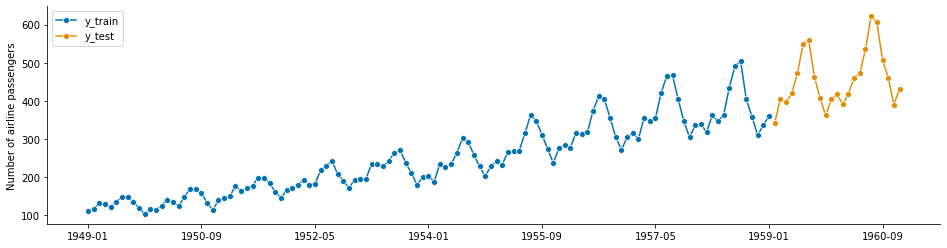

In [2]:
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=23)  # 23 samples for testing
plot_series(y_train, y_test, labels=["y_train", "y_test"])
fh = ForecastingHorizon(y_test.index, is_relative=False)
print(y_train.shape[0], y_test.shape[0])

## Results

| No. | Package | Mean Squared Error |
| --- | ------- | ------------- |
| 1 | SysIdentPy (Neural Model) | 316.54 |
| 2 | SysIdentPy (MetaMSS) | 450.99 |
| 3 | SysIdentPy (AOLS) | 476.64 |
| 4 | NeuralProphet | 501.24 |
| 5 | SysIdentPy (FROLS) | 805.95 |
| 6 | Exponential Smoothing | 910.52 |
| 7 | Prophet | 1186.00 |
| 8 | AutoArima | 1714.47 |
| 9 | Manual Arima | 2085.42 |
| 10 | ETS | 2590.05 |
| 11 | BATS | 7286.64 |
| 12 | TBATS | 7448.43 |


## SysIdentPy FROLS

805.9521186338106


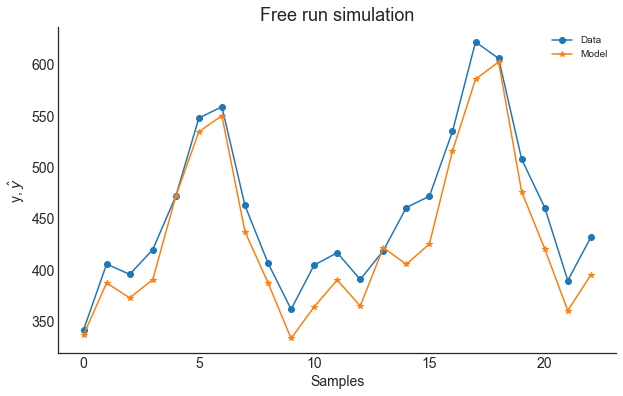

In [3]:
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=23)
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

basis_function = Polynomial(degree=1)
sysidentpy = FROLS(
    order_selection=True,
    ylag=13,  # the lags for all models will be 13
    basis_function=basis_function,
    model_type="NAR",
)
sysidentpy.fit(y=y_train)
y_test = np.concatenate([y_train[-sysidentpy.max_lag :], y_test])

yhat = sysidentpy.predict(y=y_test, forecast_horizon=23)
frols_loss = loss(
    pd.Series(y_test.flatten()[sysidentpy.max_lag :]),
    pd.Series(yhat.flatten()[sysidentpy.max_lag :]),
)
print(frols_loss)

plot_results(y=y_test[sysidentpy.max_lag :], yhat=yhat[sysidentpy.max_lag :])

## SysIdentPy AOLS

476.64996316992523


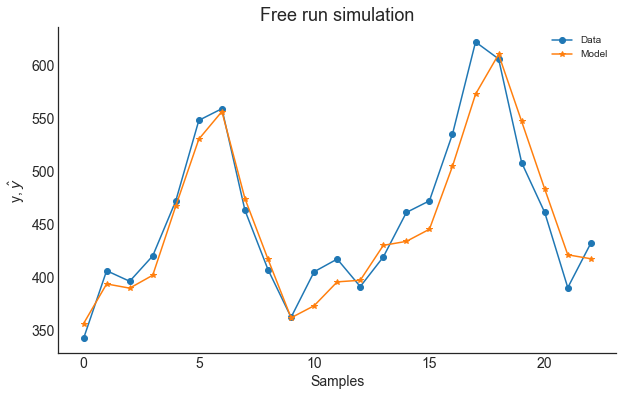

In [4]:
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=23)
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

df_train, df_test = temporal_train_test_split(y, test_size=23)
df_train = df_train.reset_index()
df_train.columns = ["ds", "y"]
df_train["ds"] = pd.to_datetime(df_train["ds"].astype(str))
df_test = df_test.reset_index()
df_test.columns = ["ds", "y"]
df_test["ds"] = pd.to_datetime(df_test["ds"].astype(str))

sysidentpy_AOLS = AOLS(
    ylag=13, k=2, L=1, model_type="NAR", basis_function=basis_function
)
sysidentpy_AOLS.fit(y=y_train)
y_test = np.concatenate([y_train[-sysidentpy_AOLS.max_lag :], y_test])

yhat = sysidentpy_AOLS.predict(y=y_test, steps_ahead=None, forecast_horizon=23)
aols_loss = loss(
    pd.Series(y_test.flatten()[sysidentpy_AOLS.max_lag :]),
    pd.Series(yhat.flatten()[sysidentpy_AOLS.max_lag :]),
)
print(aols_loss)

plot_results(y=y_test[sysidentpy_AOLS.max_lag :], yhat=yhat[sysidentpy_AOLS.max_lag :])

## SysIdentPy MetaMSS

450.992127624293


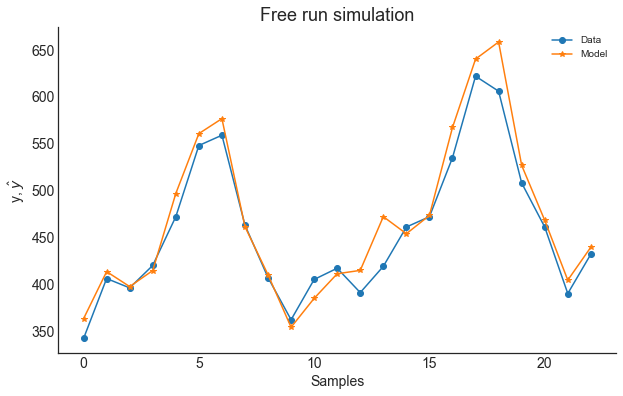

In [34]:
set_random_seed(42)

y = load_airline()
y_train, y_test, y_validation, _ = np.split(y, [100, 121, 144])
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)
y_validation = y_validation.values.reshape(-1, 1)

sysidentpy_metamss = MetaMSS(basis_function=basis_function, ylag=13, model_type="NAR")
sysidentpy_metamss.fit(y=y_train, y_test=y_test)

y_validation = np.concatenate([y_test[-sysidentpy_metamss.max_lag :], y_validation])

yhat = sysidentpy_metamss.predict(y=y_validation, steps_ahead=None, forecast_horizon=23)
metamss_loss = loss(
    pd.Series(y_validation.flatten()[sysidentpy_metamss.max_lag :]),
    pd.Series(yhat.flatten()[sysidentpy_metamss.max_lag :]),
)
print(metamss_loss)

plot_results(
    y=y_validation[sysidentpy_metamss.max_lag :],
    yhat=yhat[sysidentpy_metamss.max_lag :],
)

## SysIdentPy Neural NARX

316.54086775668776


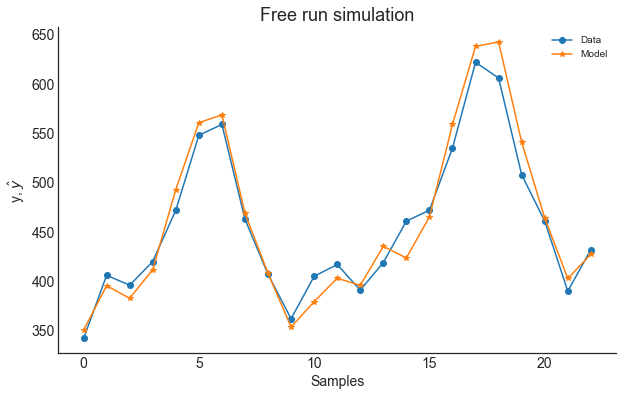

In [8]:
import torch

torch.manual_seed(42)

y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)
x_train = np.zeros_like(y_train)
x_test = np.zeros_like(y_test)


class NARX(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(13, 20)
        self.lin2 = nn.Linear(20, 20)
        self.lin3 = nn.Linear(20, 20)
        self.lin4 = nn.Linear(20, 1)
        self.relu = nn.ReLU()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.relu(z)
        z = self.lin2(z)
        z = self.relu(z)
        z = self.lin3(z)
        z = self.relu(z)
        z = self.lin4(z)
        return z


narx_net = NARXNN(
    net=NARX(),
    ylag=13,
    model_type="NAR",
    basis_function=Polynomial(degree=1),
    epochs=900,
    verbose=False,
    learning_rate=2.5e-02,
    optim_params={},  # optional parameters of the optimizer
)

narx_net.fit(y=y_train)
yhat = narx_net.predict(y=y_test, forecast_horizon=23)
narxnet_loss = loss(
    pd.Series(y_test.flatten()[narx_net.max_lag :]),
    pd.Series(yhat.flatten()[narx_net.max_lag :]),
)
print(narxnet_loss)
plot_results(y=y_test[narx_net.max_lag :], yhat=yhat[narx_net.max_lag :])

121 23


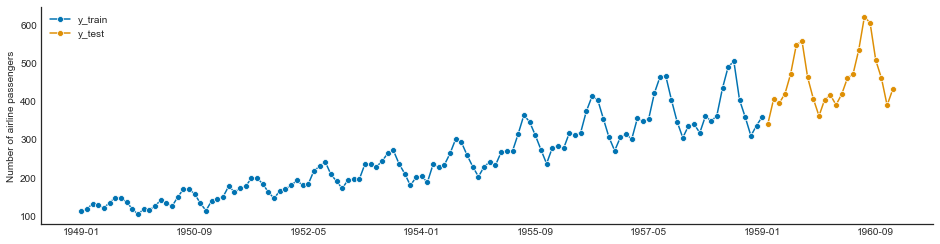

In [9]:
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=23)  # 23 samples for testing
plot_series(y_train, y_test, labels=["y_train", "y_test"])
fh = ForecastingHorizon(y_test.index, is_relative=False)
print(y_train.shape[0], y_test.shape[0])

## Exponential Smoothing

910.462659260655

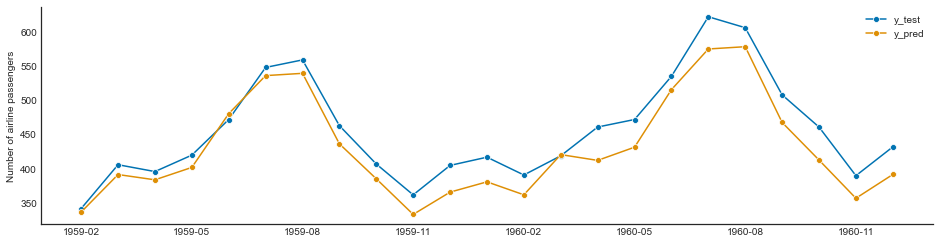

In [10]:
es = ExponentialSmoothing(trend="add", seasonal="multiplicative", sp=12)
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=23)
es.fit(y_train)
y_pred_es = es.predict(fh)

plot_series(y_test, y_pred_es, labels=["y_test", "y_pred"])
es_loss = loss(y_test, y_pred_es)
es_loss

## AutoETS

1739.117296439066

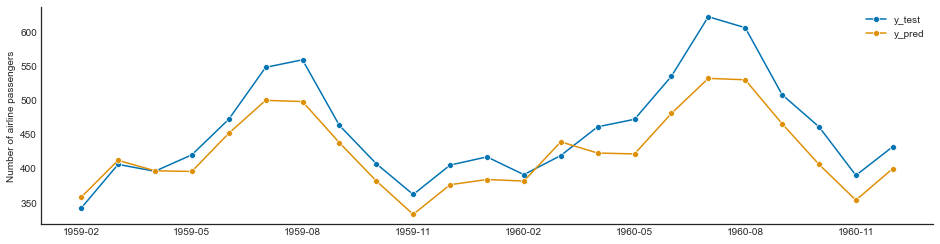

In [11]:
y = load_airline()

y_train, y_test = temporal_train_test_split(y, test_size=23)
ets = AutoETS(auto=True, sp=12, n_jobs=-1)
ets.fit(y_train)
y_pred_ets = ets.predict(fh)

plot_series(y_test, y_pred_ets, labels=["y_test", "y_pred"])
ets_loss = loss(y_test, y_pred_ets)
ets_loss

## AutoArima

1714.4753226965322

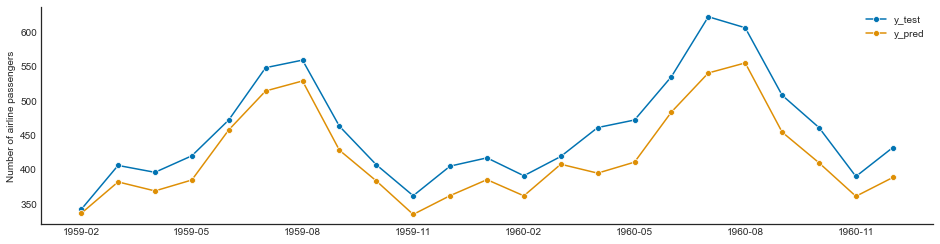

In [12]:
auto_arima = AutoARIMA(sp=12, suppress_warnings=True)
y = load_airline()

y_train, y_test = temporal_train_test_split(y, test_size=23)
auto_arima.fit(y_train)
y_pred_auto_arima = auto_arima.predict(fh)

plot_series(y_test, y_pred_auto_arima, labels=["y_test", "y_pred"])
autoarima_loss = loss(y_test, y_pred_auto_arima)
autoarima_loss

## Arima 

2085.425167938668

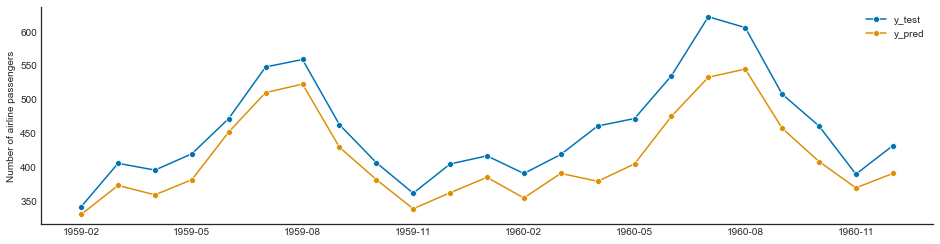

In [13]:
y = load_airline()

y_train, y_test = temporal_train_test_split(y, test_size=23)
manual_arima = ARIMA(
    order=(13, 1, 0), suppress_warnings=True
)  # seasonal_order=(0, 1, 0, 12)
manual_arima.fit(y_train)
y_pred_manual_arima = manual_arima.predict(fh)
plot_series(y_test, y_pred_manual_arima, labels=["y_test", "y_pred"])
manualarima_loss = loss(y_test, y_pred_manual_arima)
manualarima_loss

## BATS

7286.6484525676415

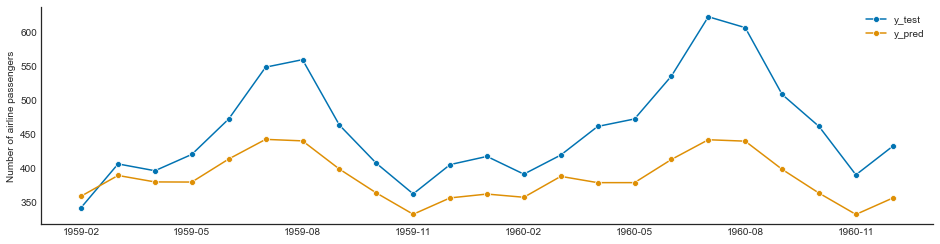

In [14]:
y = load_airline()

y_train, y_test = temporal_train_test_split(y, test_size=23)
bats = BATS(sp=12, use_trend=True, use_box_cox=False)
bats.fit(y_train)
y_pred_bats = bats.predict(fh)

plot_series(y_test, y_pred_bats, labels=["y_test", "y_pred"])
bats_loss = loss(y_test, y_pred_bats)
bats_loss

## TBATS

7448.434672875093

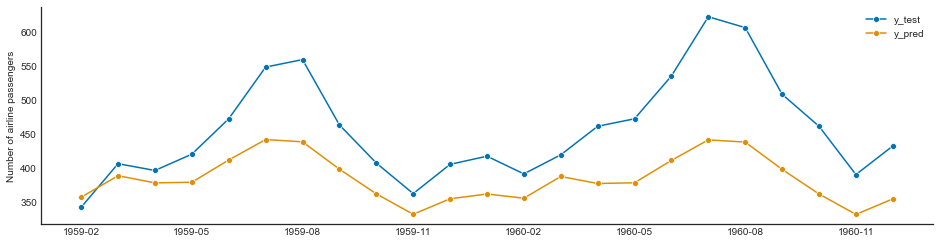

In [15]:
y = load_airline()

y_train, y_test = temporal_train_test_split(y, test_size=23)
tbats = TBATS(sp=12, use_trend=True, use_box_cox=False)
tbats.fit(y_train)
y_pred_tbats = tbats.predict(fh)
plot_series(y_test, y_pred_tbats, labels=["y_test", "y_pred"])
tbats_loss = loss(y_test, y_pred_tbats)
tbats_loss

## Prophet

1186.0045566050442

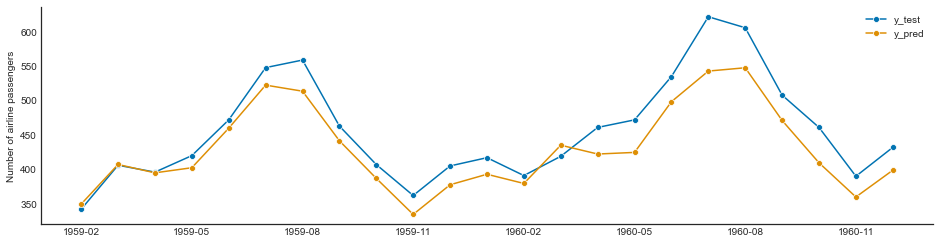

In [16]:
set_random_seed(42)

y = load_airline()

y_train, y_test = temporal_train_test_split(y, test_size=23)
z = y.copy()
z = z.to_timestamp(freq="M")
z_train, z_test = temporal_train_test_split(z, test_size=23)


prophet = Prophet(
    seasonality_mode="multiplicative",
    n_changepoints=int(len(y_train) / 12),
    add_country_holidays={"country_name": "Germany"},
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
)
prophet.fit(z_train)
y_pred_prophet = prophet.predict(fh.to_relative(cutoff=y_train.index[-1]))

y_pred_prophet.index = y_test.index
plot_series(y_test, y_pred_prophet, labels=["y_test", "y_pred"])
prophet_loss = loss(y_test, y_pred_prophet)
prophet_loss

## Neural Prophet

11-21 20:57:55 - WARNING - Parts of code may break if using other than daily data.


INFO: nprophet.utils - set_auto_seasonalities: Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.


11-21 20:57:55 - INFO - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.


INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


11-21 20:57:55 - INFO - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


11-21 20:57:55 - INFO - Auto-set batch_size to 8


INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 264


11-21 20:57:55 - INFO - Auto-set epochs to 264


 83%|████████▎ | 83/100 [00:00<00:00, 1034.46it/s]
INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-01


11-21 20:57:55 - INFO - learning rate range test found optimal lr: 1.87E-01


Epoch[264/264]: 100%|██████████| 264/264 [00:03<00:00, 66.42it/s, SmoothL1Loss=0.000325, MAE=6.38, RegLoss=0]


501.24794023767436

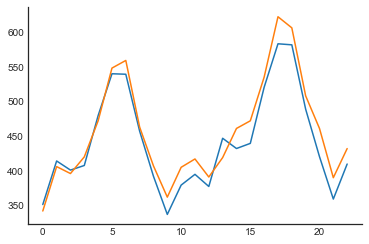

In [35]:
set_random_seed(42)

df = pd.read_csv(r".\datasets\air_passengers.csv")
m = NeuralProphet(seasonality_mode="multiplicative")
df_train = df.iloc[:-23, :].copy()
df_test = df.iloc[-23:, :].copy()
# df_val['y'] = None

m = NeuralProphet(seasonality_mode="multiplicative")

metrics = m.fit(df_train, freq="MS")

future = m.make_future_dataframe(
    df_train, periods=23, n_historic_predictions=len(df_train)
)

forecast = m.predict(future)
# fig = m.plot(forecast)
plt.plot(forecast["yhat1"].values[-23:])
plt.plot(df_test["y"].values)
neuralprophet_loss = loss(forecast["yhat1"].values[-23:], df_test["y"].values)
neuralprophet_loss

In [19]:
results = {
    "Exponential Smoothing": es_loss,
    "ETS": ets_loss,
    "AutoArima": autoarima_loss,
    "Manual Arima": manualarima_loss,
    "BATS": bats_loss,
    "TBATS": tbats_loss,
    "Prophet": prophet_loss,
    "SysIdentPy (Polynomial Model)": frols_loss,
    "SysIdentPy (Neural Model)": narxnet_loss,
    "SysIdentPy (AOLS)": aols_loss,
    "SysIdentPy (MetaMSS)": metamss_loss,
    "NeuralProphet": neuralprophet_loss,
}

sorted(results.items(), key=lambda result: result[1])

[('SysIdentPy (Neural Model)', 316.54086775668776),
 ('SysIdentPy (MetaMSS)', 450.992127624293),
 ('SysIdentPy (AOLS)', 476.64996316992523),
 ('NeuralProphet', 501.24794023767436),
 ('SysIdentPy (Polynomial Model)', 805.9521186338106),
 ('Exponential Smoothing', 910.462659260655),
 ('Prophet', 1186.0045566050442),
 ('AutoArima', 1714.4753226965322),
 ('ETS', 1739.117296439066),
 ('Manual Arima', 2085.425167938668),
 ('BATS', 7286.6484525676415),
 ('TBATS', 7448.434672875093)]